In [22]:
# !pip install networkx pandas numpy matplotlib grakel

import networkx as nx
import numpy as np
from networkx.algorithms import isomorphism
import matplotlib.pyplot as plt
import copy
import pprint
import itertools
import hashlib
from collections import Counter

## 0. Graph Edit Distance

##### Returns GED (graph edit distance) between graphs G1 and G2. Graph edit distance is a graph similarity measure analogous to Levenshtein distance for strings. It is defined as minimum cost of edit path (sequence of node and edge edit operations) transforming graph G1 to graph isomorphic to G2.

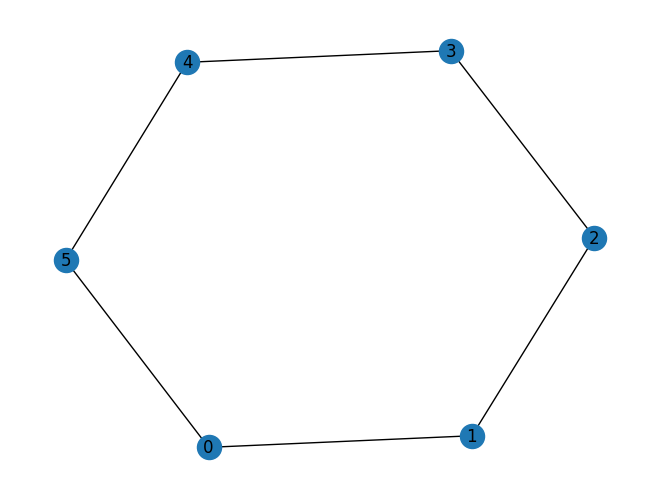

In [146]:
G1 = nx.cycle_graph(6)
G2 = nx.wheel_graph(7)
    
nx.draw(G1, with_labels = True)

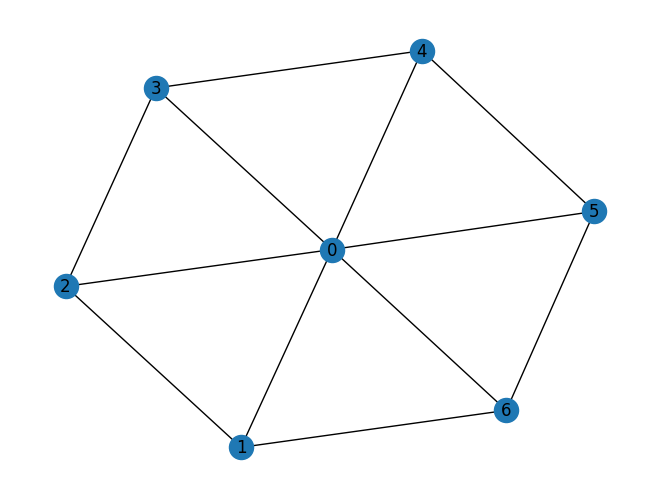

In [148]:
nx.draw(G2, with_labels = True)

In [151]:
ged = nx.graph_edit_distance(G1, G2)
print(f"The Graph Edit Distance between G1 and G2 is: {ged}")


The Graph Edit Distance between G1 and G2 is: 7.0


## 1. Degree Sequence

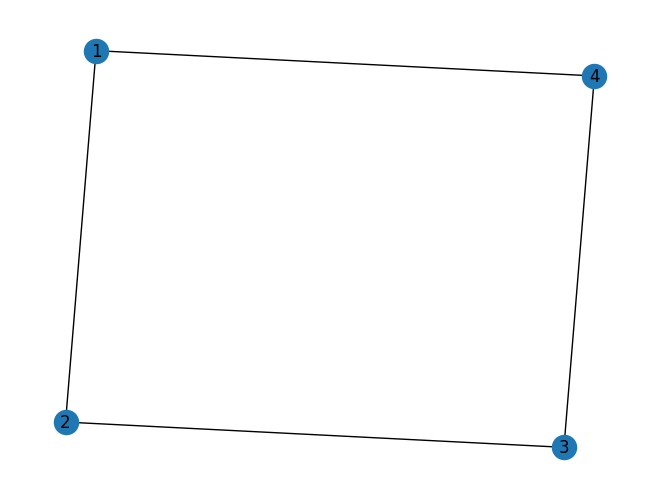

Degree sequence [2, 2, 2, 2]
Degree histogram
{2: 4}


In [70]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Create a graph and add edges
G1 = nx.Graph()
edges = [(1, 2), (2, 3), (3, 4), (4, 1)]
G1.add_edges_from(edges)

# Draw the graph
nx.draw(G1, with_labels=True)
plt.show()

# Calculate the degree sequence
degree_sequence = [d for n, d in G1.degree()]

print(f"Degree sequence {degree_sequence}")
print("Degree histogram")

# Use collections.Counter to calculate the histogram
hist1 = Counter(degree_sequence)

# Sort the histogram dictionary
sorted_hist1 = dict(sorted(hist1.items()))

print(sorted_hist1)

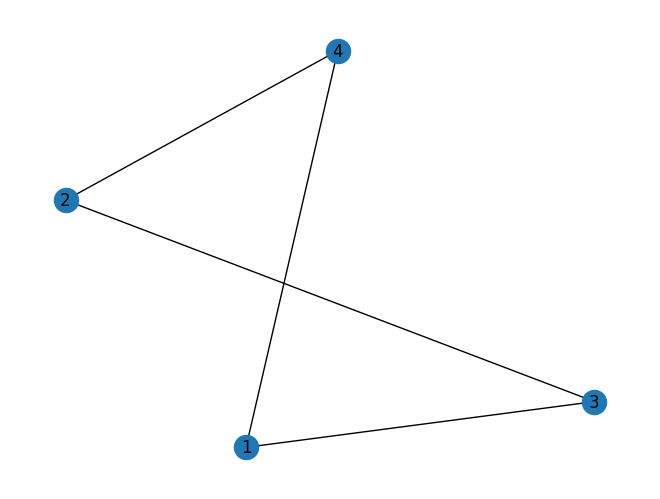

Degree sequence [2, 2, 2, 2]
Degree histogram
{2: 4}


In [71]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Create a graph and add edges
G2 = nx.Graph()
edges = [(1, 3), (1, 4), (2, 3), (2, 4)]
G2.add_edges_from(edges)

# Draw the graph
nx.draw(G2, with_labels=True)
plt.show()

# Calculate the degree sequence
degree_sequence = [d for n, d in G2.degree()]

print(f"Degree sequence {degree_sequence}")
print("Degree histogram")

# Use collections.Counter to calculate the histogram
hist2 = Counter(degree_sequence)

# Sort the histogram dictionary
sorted_hist2 = dict(sorted(hist2.items()))

print(sorted_hist2)

In [73]:
# Check if the histograms are equal
if sorted_hist1 == sorted_hist2:
    print("G1 is equal to G2")

G1 is equal to G2


## 2. Shortest Path Kernel

### 2.1 Without library (disadvantage: may not be efficient for large graphs)

[[16. 16.]
 [16. 16.]]


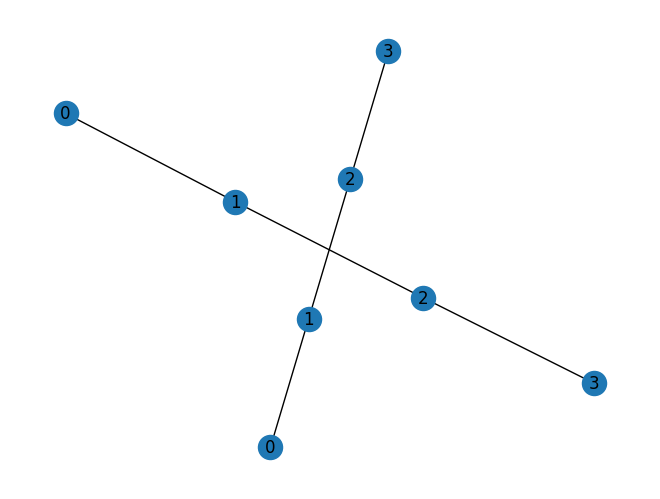

In [109]:
import networkx as nx
import numpy as np

# Define two simple graphs
G1 = nx.path_graph(4)
nx.set_node_attributes(G1, {0:'a', 1:'b', 2:'c', 3:'d'}, 'label')
nx.draw(G1, with_labels=True)

G2 = nx.path_graph(4)
nx.set_node_attributes(G2, {0:'a', 1:'a', 2:'b', 3:'c'}, 'label')
nx.draw(G2, with_labels=True)

# Compute all shortest paths in the graphs
paths_G1 = dict(nx.all_pairs_shortest_path_length(G1))
paths_G2 = dict(nx.all_pairs_shortest_path_length(G2))

# Initialize the kernel matrix
K = np.zeros((2, 2))

# Compute the shortest path kernel
for i, paths1 in enumerate([paths_G1, paths_G2]):
    for j, paths2 in enumerate([paths_G1, paths_G2]):
        # Count the number of common shortest paths
        common_paths = sum(len(set(paths1[n]).intersection(set(paths2[n]))) for n in range(4))
        K[i, j] = common_paths

print(K)

### 2.2 With GraKeL library

[[1.         0.46291005]
 [0.46291005 1.        ]]


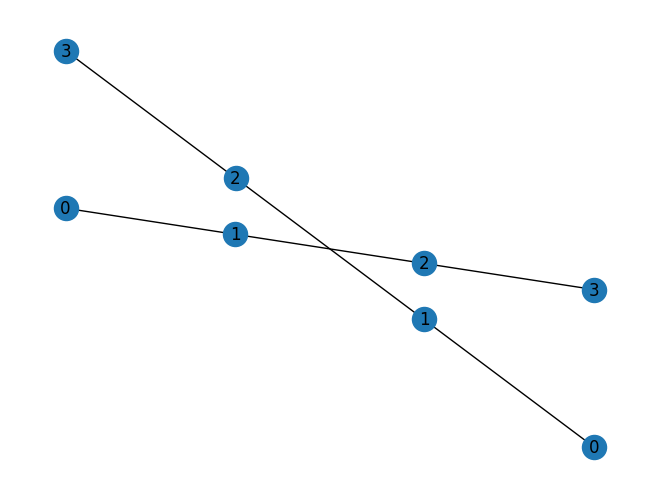

In [85]:
from grakel.utils import graph_from_networkx
from grakel import GraphKernel

# Define two simple graphs
G1 = nx.path_graph(4)
nx.set_node_attributes(G1, {0:'a', 1:'b', 2:'c', 3:'d'}, 'label')
nx.draw(G1, with_labels=True)

G2 = nx.path_graph(4)
nx.set_node_attributes(G2, {0:'a', 1:'a', 2:'b', 3:'c'}, 'label')
nx.draw(G2, with_labels=True)


nx_graphs = [G1, G2]

graphs = graph_from_networkx(nx_graphs, node_labels_tag='label')

gk = GraphKernel(kernel=[{"name": "shortest_path"}], normalize=True)
K = gk.fit_transform(graphs)

print(K)

## 3. Weisfeiler Lehman (WL) graph hash
The function iteratively aggregates and hashes neighbourhoods of each node

After each node’s neighbors are hashed to obtain updated node labels, a hashed histogram of resulting labels is returned as the final hash

Hashes are identical for isomorphic graphs and strong guarantees that non-isomorphic graphs will get different hashes

### 3.1. Initialize graphs

In [105]:
G1 = nx.Graph()
G1.add_edges_from(
    [
        (1, 2, {"label": "A"}),
        (2, 3, {"label": "A"}),
        (3, 1, {"label": "A"}),
        (1, 4, {"label": "B"}),
    ]
)
G1_node_attributes = {
    1: "A",
    2: "B",
    3: "C",
    4: "D",
}
# Set node labels by using node attributes
nx.set_node_attributes(G1, G1_node_attributes, name="label")

G2 = nx.Graph()
G2.add_edges_from(
    [
        (5, 6, {"label": "B"}),
        (6, 7, {"label": "A"}),
        (7, 5, {"label": "A"}),
        (7, 8, {"label": "A"}),
    ]
)
G2_node_attributes = {
    5: "E",
    6: "F",
    7: "G",
    8: "H",
}
# Set node labels by using node attributes
nx.set_node_attributes(G2, G2_node_attributes, name="label")


{1: 'A', 2: 'B', 3: 'C', 4: 'D'}


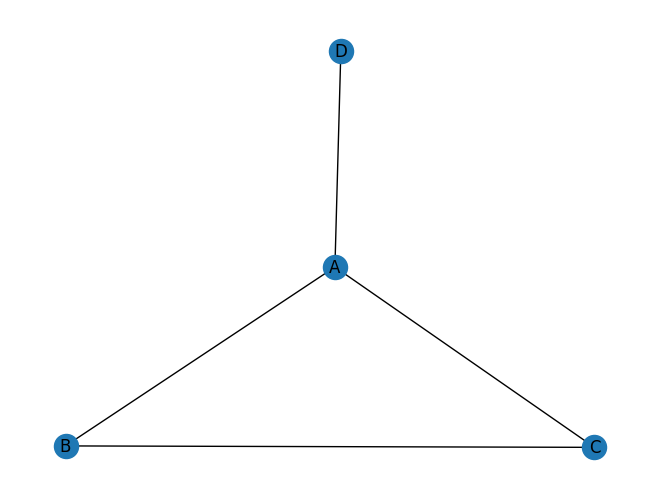

In [30]:
def draw_graph_with_labels(graph):
    labels = dict()
    names = nx.get_node_attributes(graph, 'label')
    print(names)
    for node in graph.nodes:
        labels[node] = f"{names[node]}"
    nx.draw(graph, labels=labels)
    

draw_graph_with_labels(G1)

{5: 'E', 6: 'F', 7: 'G', 8: 'H'}


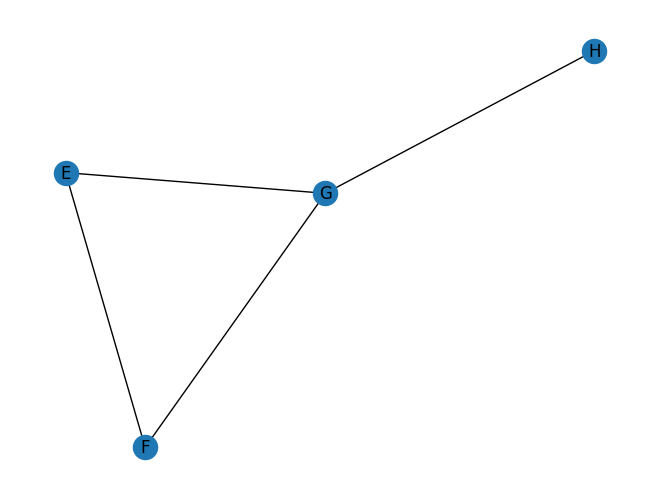

In [31]:
draw_graph_with_labels(G2)

### 3.2. Without labels

In [98]:
"""
Functions for hashing graphs to strings.
Isomorphic graphs should be assigned identical hashes.
For now, only Weisfeiler-Lehman hashing is implemented.
"""
from hashlib import blake2b

def _hash_label(label, digest_size):
    return blake2b(label.encode("ascii"), digest_size=digest_size).hexdigest()

def _init_node_labels(G, edge_attr, node_attr):
    if node_attr:
        return {u: str(dd[node_attr]) for u, dd in G.nodes(data=True)}
    elif edge_attr:
        return {u: "" for u in G}
    else:
        return {u: str(deg) for u, deg in G.degree()}

def _neighborhood_aggregate(G, node, node_labels, edge_attr=None):
    """
    Compute new labels for given node by aggregating
    the labels of each node's neighbors.
    """
    label_list = []
    for nbr in G.neighbors(node):
        prefix = "" if edge_attr is None else str(G[node][nbr][edge_attr])
        label_list.append(prefix + node_labels[nbr])
    return node_labels[node] + "".join(sorted(label_list))

def weisfeiler_lehman_graph_hash(
    G, edge_attr=None, node_attr=None, iterations=3, digest_size=16
):
    def weisfeiler_lehman_step(G, labels, edge_attr=None):
        """
        Apply neighborhood aggregation to each node
        in the graph.
        Computes a dictionary with labels for each node.
        """
        new_labels = {}
        for node in G.nodes():
            label = _neighborhood_aggregate(G, node, labels, edge_attr=edge_attr)
            new_labels[node] = _hash_label(label, digest_size)
        return new_labels

    # set initial node labels
    node_labels = _init_node_labels(G, edge_attr, node_attr)

    subgraph_hash_counts = []
    for _ in range(iterations):
        node_labels = weisfeiler_lehman_step(G, node_labels, edge_attr=edge_attr)
        counter = Counter(node_labels.values())
        # sort the counter, extend total counts
        subgraph_hash_counts.extend(sorted(counter.items(), key=lambda x: x[0]))

    # hash the final counter
    return _hash_label(str(tuple(subgraph_hash_counts)), digest_size)

In [96]:
g1_hash = weisfeiler_lehman_graph_hash(G1)
g2_hash = weisfeiler_lehman_graph_hash(G2)

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

First  graph hash: 69144809aea48cb46eae9c3950f24a15
Second graph hash: 69144809aea48cb46eae9c3950f24a15
Checking graph isomorphic: True


### 3.3. With node labels

In [101]:
g1_hash = weisfeiler_lehman_graph_hash(G1, node_attr="label")
g2_hash = weisfeiler_lehman_graph_hash(G2, node_attr="label")

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

First  graph hash: 8b23f01c114c37a15d36cc47b8e24deb
Second graph hash: 8f8582a09649e26e896a927a15fa801f
Checking graph isomorphic: False


### 3.4. With edge labels

In [107]:
g1_hash = weisfeiler_lehman_graph_hash(G1, edge_attr="label")
g2_hash = weisfeiler_lehman_graph_hash(G2, edge_attr="label")

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

First  graph hash: c653d85538bcf041d88c011f4f905f10
Second graph hash: 3dcd84af1ca855d0eff3c978d88e7ec7
Checking graph isomorphic: False


### 3.5. WL implementation
It contains different methods to construct the WL-Test and k-WL-Test.

#### 3.5.1. Implement the method to generate the WL-Test
![image info](./data/WL.png)

The set of elements are the nodes of the graph. 

The initial color is the same for everybody and is only the ‘1’ string, and finally, its neighborhood is only the connected nodes to the node of interest.

In [108]:
# A base function to calculate WL
def compute_base_WL(graph, k, verbose, n_set, initial_colors_func, find_neighbors_func):    
    G, n = n_set(graph)
    colors = initial_colors_func(n)
    old_colors = copy.deepcopy(colors)
    
    for i in range(len(n)):
        for node in n:
            neigh_colors = "".join([colors[i][0] for i in find_neighbors_func(G, n, node)])
            colors[node].extend([neigh_colors])
            colors[node].sort()
            
        # Update with the hash
        colors = {i: [hashlib.sha224("".join(colors[i]).encode('utf-8')).hexdigest()] for i in colors}
        
        if list(Counter([item for sublist in colors.values() for item in sublist]).values()) == list(Counter([item for sublist in old_colors.values() for item in sublist]).values()) and i != 0:
            if verbose:
                print(f'Converged at iteration {i}!')
            break
        
        old_colors = copy.deepcopy(colors)
    canonical_form = sorted(Counter([item for sublist in colors.values() for item in sublist]).items())
    
    if verbose:
        print(f'Canonical Form Found: \n {canonical_form} \n')
        
    return canonical_form


In [36]:
def WL(G, k=2, verbose=False):
    # The function to generate the graph with set of nodes in integer labels
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        return G, list(G.nodes())
    
    # The function to initialize colors for nodes
    def set_initial_colors(n):
        return {i: [hashlib.sha224("1".encode('utf-8')).hexdigest()] for i in n}
    
    # The function to check neighbors of a node
    def find_neighbors(G, n, node):
        return G.neighbors(node)
    
    # Compute WL test
    return compute_base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)


#### 3.5.2. Compute k-WL
The k-dimensional Weisfeiler Lehman test extends the test to coloring k-tuples of nodes.

![image info](./data/kWL.png)

#### The differences from the WL-Test:

- The set of elements is based on V^k and not on V anymore.

- The initial color is not the same for every node, now it depends on the nodes that compose the element
- The neighborhood of each element is defined according to bellow equation.

![image info](./data/kWL_eq.png)

In [37]:
def kWL(G, k, verbose=False):
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        V = list(G.nodes())
        
        # Considering node with k-tuples of nodes
        V_k = [comb for comb in itertools.combinations(V, k)]
        return G, V_k

    def set_initial_colors(n):
        return {i: [hashlib.sha224(str(i).encode('utf-8')).hexdigest()] for i in n}

    # Find k-hop neighbors
    def find_neighbors(G, V_k, node):
        return [n for n in V_k if len(set(n) - set(V_k[V_k.index(node)])) == 1]

    return compute_base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)

In [117]:
def check_graph_isomorphic(G1, G2, method='WL', k=2, verbose=False):
    methods = {
        'WL': WL,
        'kWL': kWL
    }

    # If two graphs have different numbers of nodes they cannot be isomorphic
    if len(G1.nodes()) != len(G2.nodes()):
        if verbose:
            print('Non-Isomorphic by different number of nodes!')
        return False
    
    g1_hash = methods[method](G1, k, verbose)
    g2_hash = methods[method](G2, k, verbose)

    print(f"Checking graph isomorphic: {g1_hash==g2_hash}")
    return

#### 3.5.3. Test WL
Comparing the graph on the left L and the graph on the right R

![image info](./data/example_isomorphic.png)

In [118]:
# Create graph L
L = nx.Graph(
    [
        ("a", "g"),
        ("a", "h"),
        ("a", "i"),
        ("g", "b"),
        ("g", "c"),
        ("b", "h"),
        ("b", "j"),
        ("h", "d"),
        ("c", "i"),
        ("c", "j"),
        ("i", "d"),
        ("d", "j"),
    ]
)

# Create graph R
R = nx.Graph(
    [
        (1, 2),
        (1, 5),
        (1, 4),
        (2, 6),
        (2, 3),
        (3, 7),
        (3, 4),
        (4, 8),
        (5, 6),
        (5, 8),
        (6, 7),
        (7, 8),
    ]
)

check_graph_isomorphic(R, L, k=1, verbose=True, method='WL')

Converged at iteration 1!
Canonical Form Found: 
 [('9f43c972c6d21dec7641f34208d88a86d8cd791a839d8ae95cac66e7', 8)] 

Converged at iteration 1!
Canonical Form Found: 
 [('9f43c972c6d21dec7641f34208d88a86d8cd791a839d8ae95cac66e7', 8)] 

Checking graph isomorphic: True


#### 3.5.4. Test k-WL with k = 3

In [119]:
check_graph_isomorphic(R, L, k=2, verbose=True, method='kWL')

Converged at iteration 1!
Canonical Form Found: 
 [('03cd0379aec8717d03c0431e5963bc6953492d4cf6a15a3e2e9dea45', 1), ('0c6b9ecbf69916fcd99d8aaaeb8919785245647ad294290a81999b0c', 1), ('0fb6a4170702a2f2556f9b2f178ce20dd36b8dc008253f0054bec42b', 1), ('17931a26071743dd0164a4e1fa6c5b2b7427b0494d71d1346f1063a6', 1), ('27d2517f4a598b0ecc8a86c13c4cc7e0c3e1a21f111b1f4750eba680', 1), ('2ab6c5f96589faaafa4e0c6f5b5cfd8ed67044dba6cccdfcb032d785', 1), ('36ea5314d1355aea4bdadbb1fbc4541ce81144a43f92d13d2c2847ba', 1), ('3833b3af52de3ae2dd433c68ba2ae1d8b2f035ab35b300870d56ea12', 1), ('4205be6c27a2b9584d1ca133393d0893804f5416a9b557863edf80c9', 1), ('492031c674a1b333800d6ba4a33e4bf0029c591a66a7469251e62e0f', 1), ('4f52e044162c6c06a19acbf86457b170526991a6777a86995d7c1412', 1), ('5443c3d2dffd6e9f500591d82a018a4d4173e426c09fe9b85ca17347', 1), ('5ddecb48972d7bb3a16ccca24aeb38057b7ba0beefed39beee424ca2', 1), ('70bffeed5d01986b673191d61a3186c559277fca5641d31617d47a82', 1), ('71b8ad49e4177385565afb91e77218120482d

## 4. WL Subtree Kernel

WL subtree kernel value: 4


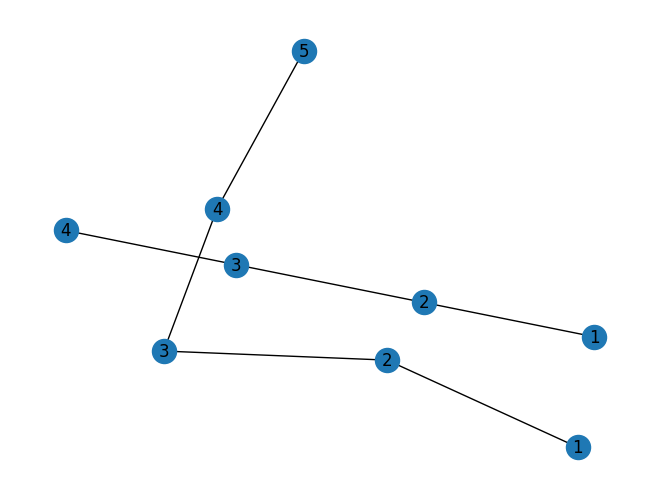

In [130]:
import networkx as nx
import numpy as np

def weisfeiler_lehman_subtree_kernel(G1, G2, h):
    """
    Compute the Weisfeiler-Lehman subtree kernel between two graphs.

    Parameters:
        G1 (networkx.Graph): The first input graph.
        G2 (networkx.Graph): The second input graph.
        h (int): The number of iterations in the Weisfeiler-Lehman algorithm.

    Returns:
        float: The similarity score between the two graphs.
    """
    # Compute the node labels using the initial degree as the label
    labels1 = {node: [G1.degree(node)] for node in G1.nodes()}
    labels2 = {node: [G2.degree(node)] for node in G2.nodes()}

    for i in range(h):
        # Update node labels based on the multiset of labels in the neighborhood
        new_labels1 = {}
        new_labels2 = {}
        for node in G1.nodes():
            neighbors_labels = sorted(labels1[n] for n in G1.neighbors(node))
            new_labels1[node] = labels1[node] + neighbors_labels
        for node in G2.nodes():
            neighbors_labels = sorted(labels2[n] for n in G2.neighbors(node))
            new_labels2[node] = labels2[node] + neighbors_labels
        labels1 = new_labels1
        labels2 = new_labels2

    # Compute the kernel value by comparing label distributions
    kernel_value = 0
    for label1 in labels1.values():
        for label2 in labels2.values():
            if label1 == label2:
                kernel_value += 1

    return kernel_value

# Define two simple graphs
G1_nx = nx.path_graph(4)
nx.set_node_attributes(G1, {0:'a', 1:'b', 2:'c', 3:'d'}, 'label')
nx.draw(G1, with_labels=True)

G2_nx = nx.path_graph(4)
nx.set_node_attributes(G2, {0:'a', 1:'a', 2:'b', 3:'c'}, 'label')
nx.draw(G2, with_labels=True)


kernel_value = weisfeiler_lehman_subtree_kernel(G1, G2, h=2)
print("WL subtree kernel value:", kernel_value)


## 5. Pyramid Match (PM) graph kernel: 
Embeds the vertices of the input graphs in a vector space. 

It then partitions the feature space into regions of increasingly larger size and takes a weighted sum of the matches that occur at each level.

In [134]:
import networkx as nx
import numpy as np

def pyramid_match_kernel(G1, G2, levels):
    """
    Compute the Pyramid Match graph kernel between two graphs.

    Parameters:
        G1 (networkx.Graph): The first input graph.
        G2 (networkx.Graph): The second input graph.
        levels (int): The number of levels in the pyramid decomposition.

    Returns:
        float: The similarity score between the two graphs.
    """
    # Extract node and edge attributes for each graph
    node_attrs_G1 = nx.get_node_attributes(G1, 'attribute')
    node_attrs_G2 = nx.get_node_attributes(G2, 'attribute')
    edge_attrs_G1 = nx.get_edge_attributes(G1, 'weight')
    edge_attrs_G2 = nx.get_edge_attributes(G2, 'weight')

    # Initialize kernel matrix
    kernel_matrix = np.zeros((levels, levels))

    # Perform pyramid decomposition and compute similarity at each level
    for level in range(levels):
        # Extract features for current level
        features_G1 = extract_features(G1, node_attrs_G1, edge_attrs_G1, level)
        features_G2 = extract_features(G2, node_attrs_G2, edge_attrs_G2, level)

        # Compute similarity between feature vectors
        similarity = compute_similarity(features_G1, features_G2)

        # Update kernel matrix
        kernel_matrix[level, level] = similarity

    # Aggregate similarities from all levels
    kernel_value = np.sum(kernel_matrix)

    return kernel_value

def extract_features(G, node_attrs, edge_attrs, level):
    """
    Extract features for a given level of the pyramid decomposition.

    Parameters:
        G (networkx.Graph): The input graph.
        node_attrs (dict): Node attributes of the graph.
        edge_attrs (dict): Edge attributes of the graph.
        level (int): The current level of the pyramid decomposition.

    Returns:
        numpy.ndarray: Feature vector for the given level.
    """
    # Extract node and edge features based on the level
    # (This is a simplified example, actual feature extraction may be more complex)
    node_features = [attr for node in G.nodes() for attr in node_attrs[node]]
    edge_features = [edge_attrs[edge] for edge in G.edges()]

    # Concatenate node and edge features into a single feature vector
    features = np.concatenate((node_features, edge_features))

    return features

def compute_similarity(features_G1, features_G2):
    """
    Compute similarity between feature vectors.

    Parameters:
        features_G1 (numpy.ndarray): Feature vector of graph G1.
        features_G2 (numpy.ndarray): Feature vector of graph G2.

    Returns:
        float: Similarity score between the two feature vectors.
    """
    # Compute similarity between feature vectors (e.g., using cosine similarity)
    similarity = np.dot(features_G1, features_G2) / (np.linalg.norm(features_G1) * np.linalg.norm(features_G2))

    return similarity

# Define two simple graphs
G1 = nx.Graph()
G1.add_edge(1, 2, weight=0.5)
G1.add_edge(2, 3, weight=0.8)
G1.nodes[1]['attribute'] = [0.1, 0.2]
G1.nodes[2]['attribute'] = [0.3, 0.4]
G1.nodes[3]['attribute'] = [0.5, 0.6]

G2 = nx.Graph()
G2.add_edge(1, 2, weight=0.6)
G2.add_edge(2, 3, weight=0.7)
G2.nodes[1]['attribute'] = [0.1, 0.2]
G2.nodes[2]['attribute'] = [0.3, 0.4]
G2.nodes[3]['attribute'] = [0.5, 0.6]

kernel_value = pyramid_match_kernel(G1, G2, levels=3)
print("Pyramid Match graph kernel value:", kernel_value)


Pyramid Match graph kernel value: 2.9833343913998465


## 6. Random Walk Kernel

In [57]:
import networkx as nx
import random

def random_walk_kernel(graph, walk_length=2):
    # Initialize the kernel to zero
    kernel = 0

    # Get a list of nodes
    nodes = list(graph.nodes)

    # Perform a random walk for each node in the graph
    for node in nodes:
        # Start the walk at the current node
        walk = [node]

        # Continue the walk
        for i in range(walk_length):
            # Get the neighbors of the current node
            neighbors = list(nx.all_neighbors(graph, walk[-1]))

            # If the current node has no neighbors, end the walk
            if not neighbors:
                break

            # Choose a neighbor at random
            next_node = random.choice(neighbors)

            # Add the chosen neighbor to the walk
            walk.append(next_node)

        # Update the kernel
        kernel += len(walk) - 1

    return kernel

In [58]:
import networkx as nx

# Create a simple graph
G = nx.Graph()
G.add_edge('A', 'B')
G.add_edge('B', 'C')
G.add_edge('C', 'A')
G.add_edge('A', 'D')

# Call the random_walk_kernel function
kernel_value = random_walk_kernel(G, walk_length=2)

print(f"The random walk kernel value is: {kernel_value}")

The random walk kernel value is: 8


## 7. Graphlet Kernel

In [173]:
import networkx as nx
import numpy as np
from itertools import combinations

def compute_graphlet_counts(G, k):
    """
    Compute the counts of k-node graphlets in the given graph.

    Parameters:
        G (networkx.Graph): The input graph.
        k (int): The size of the graphlets to count.

    Returns:
        dict: A dictionary containing the counts of k-node graphlets.
    """
    graphlet_counts = {graphlet: 0 for graphlet in range(1, k+1)}

    for node in G.nodes():
    # Generate the induced subgraph with node and its neighbors
        subgraph_nodes = [node] + list(G.neighbors(node))
        subgraph = G.subgraph(subgraph_nodes)

        # Count the occurrences of k-node graphlets in the subgraph
        for graphlet_size in range(1, k+1):
            for subgraph_nodes_subset in combinations(subgraph_nodes, graphlet_size):
                if G.subgraph(subgraph_nodes_subset).number_of_nodes() == graphlet_size:
                    graphlet_counts[graphlet_size] += 1

    return graphlet_counts

def compute_graphlet_kernel(G1, G2, k):
    """
    Compute the graphlet kernel between two graphs.

    Parameters:
        G1 (networkx.Graph): The first input graph.
        G2 (networkx.Graph): The second input graph.
        k (int): The size of the graphlets to count.

    Returns:
        float: The similarity score between the two graphs.
    """
    # Compute the counts of k-node graphlets in each graph
    graphlet_counts_G1 = compute_graphlet_counts(G1, k)
    graphlet_counts_G2 = compute_graphlet_counts(G2, k)

    # Compute the kernel value by comparing the counts of graphlets
    kernel_value = 0
    for graphlet in range(1, k+1):
        kernel_value += min(graphlet_counts_G1[graphlet], graphlet_counts_G2[graphlet])

    return kernel_value

# Define two simple graphs
G1 = nx.Graph([(1, 2), (2, 3), (3, 4), (4, 1)])
G2 = nx.Graph([(1, 2), (2, 3), (3, 4)])

k = 3  # Size of the graphlets to count

kernel_value = compute_graphlet_kernel(G1, G2, k)
print("Graphlet kernel value:", kernel_value)


Graphlet kernel value: 20
